In [45]:
#  given list to get c , c2 c,3...
import numpy as np
import random
import pickle
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import chain

#open Cliff_indices1 put into data
with open("Cliff_indices_4.pkl", "rb") as f:  
    data = pickle.load(f)
f.close()

#open Prim put into Prim
with open("Prim_exp.pkl", "rb") as f2:  
    Prim = pickle.load(f2)
f2.close()

#open Prim_inv put into Prim_inv
with open("Inverse_of_prim.pkl", "rb") as f3:  
    Prim_inv = pickle.load(f3)
f3.close()

with open("Prim_perfect.pkl", "rb") as f4:  
    Prim_perfect = pickle.load(f4)
f4.close() 

####################################################initial state#############################################################
#given probability  NOT Probability amplitude
#[target , ud , du , dd]
e_ud=0.01                 #error probability  NOT Probability amplitude
e_du=0                  
e_dd=0
    
def error_initial_state(e1,e2,e3):
    return np.matrix([[math.sqrt(1-e1*e1-e2*e2-e3*e3),math.sqrt(e1),math.sqrt(e2),math.sqrt(e3)]]).getH()
initial = error_initial_state(e_ud,e_du,e_dd)

####################################################initial state#############################################################
#############################################Randomized Benchmarking##########################################################
#given list , return s = c0*c1*c2....

def Is_Inverse(A, B):
    if np.allclose(np.absolute(np.trace(np.dot(A, B))), 4):
        return True
    else:
        return False
    
def fidelity(M_exp, M):
    return np.absolute(np.trace(np.dot(M_exp.conj().T, M)))/4

def get_s(g1):               
    p = np.identity(4)                             # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            p = p@Prim[array[j]]                  #s=p*p*p*p*p*p*p....
    return p

def get_s_perfect(g1):               
    p = np.identity(4)                             # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            p = p@Prim_perfect[array[j]]                  #s=p*p*p*p*p*p*p....
    return p
def get_perfect_unitary(seq):                 #Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)                             
    for j in range(len(seq)):
        p = p@Prim_perfect[seq[j]]                  
    return p


def get_nonperfect_unitary(seq):                 #Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)                             
    for i in range(len(seq)):
        p = p@Prim[seq[i]]                  
    return p

#given list , return c^-1 
def c_m(c1):
    a = get_s_perfect(c1)
    for k in range(len(data)):
        b = get_perfect_unitary(data[k])
        if Is_Inverse(a, b):
            return get_nonperfect_unitary(data[k])
#########################INTERLEAVE###################################################
interleave = True
target_gate_index=[0]
target_gate = Prim_perfect[target_gate_index[0]]
###################################################################

I = np.identity(4)
Probability_mean = []
Probability_std = []

RB_repetition = 10                          # samples for each data point (算標準差即是使用每個data point對應的N個數據)
L= np.linspace(3, 61, 30).astype(int)       # of clifford gate=[3,5,7...,61]
K_L = 51                                    # same L ,randomly choose # of K_L sequence
M_K_L = 1                                   # measurement
for l in L:                                 # random choose l:(1,2,3.....30)
    results = []
    for rb_repetition in range(RB_repetition):
        number_uu = 0
        print("L = ", l, "; RB_repetition_data", rb_repetition , "is calculating...")
        for k_l in range(K_L):
            if(interleave):           
                sequence_index=list(chain.from_iterable(zip(random.choices(data,k=int((l-1)/2)), [target_gate_index]*int((l-1)/2))))#把target gate seq 插入
            else: 
                sequence_index=random.choices(data,k=l)   #interleave off  隨機選取 長度*2 
            seq_k_l = get_s(sequence_index)@c_m(sequence_index)          # k_th seq: c1@c2.....  @cm+1
#             print(fidelity(seq_k, I))

#############################################Randomized Benchmarking##########################################################
#############################################Readout##########################################################################
            e_readout=0.05
            final_prob=np.square(np.abs(seq_k_l@initial))
            err = final_prob[0]*e_readout
            final_prob[0] -= err   #這邊是否會造成機率不守恒? 只有uu態機率因readout減少但其他態機率沒變?
            for i in range(1, 4): final_prob[i] += err/3
            uu_count=[1,0,0,0]
            number_distribution=random.choices(uu_count,weights=final_prob, k=M_K_L)
            number_uu=number_uu+number_distribution[0]
        results.append(number_uu/K_L/M_K_L)
    Probability_mean.append(np.mean(results))
    Probability_std.append(np.std(results))

#saveing the results
f5 = open('2q_RB_simu_L.pkl', 'wb')
pickle.dump(L , f5)
f5.close()    

f6 = open('2q_RB_simu_Probability_mean.pkl', 'wb')
pickle.dump(Probability_mean , f6)
f6.close()  

f7 = open('2q_RB_simu_Probability_std.pkl', 'wb')
pickle.dump(Probability_std , f7)
f7.close()  
# Fitting function

def func(x, A, B, p):
    return A * p**L + B

# def func(x, A):
#     return  * (1 - 4/3*0.053)**x + 0.25

popt, pcov = curve_fit(func, L, Probability_mean,bounds=(0, [1, 1, 1]),maxfev=5000)      
#p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)


p_rb=0.96
print("F_Ciff = 1 - r = ", 1-0.75*(1-popt[2]/p_rb))
print("A = ", popt[0])
print("B = ", popt[1])

plt.errorbar(L, Probability_mean, yerr=Probability_std, fmt='o', markersize=4, capsize=3)
plt.plot(L, func(L, *popt), 'r-')
# plt.plot(x, func(x, 0.75, 0.25, 0.053), 'b-')
plt.ylim(top=1.0)
plt.xlabel("Number of Cliffords (L)")
plt.ylabel("Proj. State Prob.")
plt.title("Two-qubit RB Fitting")

L =  3 ; data 1 is calculating...
L =  3 ; data 2 is calculating...
L =  3 ; data 3 is calculating...
L =  3 ; data 4 is calculating...
L =  3 ; data 5 is calculating...
L =  3 ; data 6 is calculating...
L =  3 ; data 7 is calculating...
L =  3 ; data 8 is calculating...
L =  3 ; data 9 is calculating...
L =  3 ; data 10 is calculating...
L =  5 ; data 1 is calculating...
L =  5 ; data 2 is calculating...
L =  5 ; data 3 is calculating...
L =  5 ; data 4 is calculating...
L =  5 ; data 5 is calculating...
L =  5 ; data 6 is calculating...
L =  5 ; data 7 is calculating...
L =  5 ; data 8 is calculating...
L =  5 ; data 9 is calculating...
L =  5 ; data 10 is calculating...
L =  7 ; data 1 is calculating...
L =  7 ; data 2 is calculating...
L =  7 ; data 3 is calculating...
L =  7 ; data 4 is calculating...
L =  7 ; data 5 is calculating...
L =  7 ; data 6 is calculating...
L =  7 ; data 7 is calculating...
L =  7 ; data 8 is calculating...
L =  7 ; data 9 is calculating...
L =  7 ; dat

L =  49 ; data 6 is calculating...
L =  49 ; data 7 is calculating...
L =  49 ; data 8 is calculating...
L =  49 ; data 9 is calculating...
L =  49 ; data 10 is calculating...
L =  51 ; data 1 is calculating...
L =  51 ; data 2 is calculating...
L =  51 ; data 3 is calculating...
L =  51 ; data 4 is calculating...
L =  51 ; data 5 is calculating...
L =  51 ; data 6 is calculating...
L =  51 ; data 7 is calculating...
L =  51 ; data 8 is calculating...
L =  51 ; data 9 is calculating...
L =  51 ; data 10 is calculating...
L =  53 ; data 1 is calculating...
L =  53 ; data 2 is calculating...
L =  53 ; data 3 is calculating...
L =  53 ; data 4 is calculating...
L =  53 ; data 5 is calculating...
L =  53 ; data 6 is calculating...
L =  53 ; data 7 is calculating...
L =  53 ; data 8 is calculating...
L =  53 ; data 9 is calculating...
L =  53 ; data 10 is calculating...
L =  55 ; data 1 is calculating...
L =  55 ; data 2 is calculating...
L =  55 ; data 3 is calculating...
L =  55 ; data 4 

Text(0.5, 1.0, 'Two-qubit RB Fitting')

qinfer solution for (rbp,p,A,B) is (0.97356,0.97329,0.702,0.238).
F_Ciff = 1 - r =  1.000204201547167
0.9475550555443928


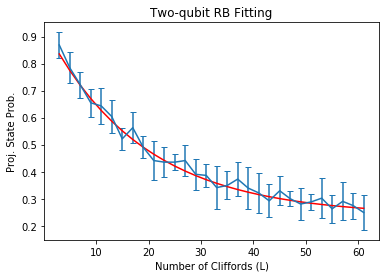

In [2]:
import numpy as np
import random
import pickle
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qinfer as qi
from itertools import chain
%matplotlib inline
L= np.linspace(3, 61, 30).astype(int)
with open('2q_RB_simu_y.pkl', 'rb') as f6:
    y = pickle.load(f6)
f6.close()   
with open('2q_RB_simu_yerr.pkl', 'rb') as f7:
    yerr=pickle.load(f7)
f7.close() 
# Fitting function
def func(x, A, B, p):
    return A * p**x + B

#popt, pcov = curve_fit(func, L, y)      
#p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)
n_counts=100
counts=[int(i*n_counts) for i in y]
data = np.column_stack([counts, L, n_counts * np.ones_like(counts),False* np.ones_like(counts)])
mean, cov, extra = qi.simple_est_rb(data, return_all=True,interleaved=True, n_particles=120000, p_min=0.8)
print("qinfer solution for (rbp,p,A,B) is ({:.5f},{:.5f},{:.3f},{:.3f}).".format(*mean))
print("F_Ciff = 1 - r = ", 1-0.75*(1-mean[0]/mean[1]))
prp = 0.9467
plt.errorbar(L, y, yerr=yerr, markersize=4, capsize=3)
plt.plot(L, mean[2]*(mean[0]*mean[1])**L+mean[3], 'r-')

plt.xlabel("Number of Cliffords (L)")
plt.ylabel("Proj. State Prob.")
plt.title("Two-qubit RB Fitting")
print(mean[0]*mean[1])

In [1]:
import numpy as np
import random
import pickle
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import chain
%matplotlib inline
L= np.linspace(3, 61, 30).astype(int)
with open('2q_RB_simu_Probability_mean.pkl', 'rb') as f6:
    y = pickle.load(f6)
f6.close()   
with open('2q_RB_simu_Probability_std.pkl', 'rb') as f7:
    yerr=pickle.load(f7)
f7.close() 
# Fitting function

def func(x, A, B, p):
    return A * p**x + B
popt, pcov = curve_fit(func, L, y,bounds=(0, [1, 1, 1]),maxfev=5000)     
#p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)
p_rb= 0.9467
print("F_Ciff = 1 - r = ", 1-0.75*(1-popt[2]/p_rb))
print("A = ", popt[0])
print("B = ", popt[1])
print("p = ", popt[2])
plt.errorbar(L, y, yerr=yerr, markersize=4, capsize=3)
plt.plot(L, func(L, *popt), 'r-')
# plt.plot(x, func(x, 0.75, 0.25, 0.053), 'b-')
#plt.ylim(top=1.0)
plt.xlabel("Number of Cliffords (L)")
plt.ylabel("Proj. State Prob.")
plt.title("Two-qubit RB Fitting")


FileNotFoundError: [Errno 2] No such file or directory: '2q_RB_simu_Probability_mean.pkl'